In [63]:
cd C:\\Users\\sanke\\datasets\\Shampoo

C:\Users\sanke\datasets\Shampoo


# Importing Libraries.

In [64]:
# importing important data analysis , manipulation , and visualisation libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [65]:
df = pd.read_csv('shampoo.csv')
df.head()

,Month,Sales of shampoo over a three year period
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [66]:
df.dtypes

Month                                         object
Sales of shampoo over a three year period    float64
dtype: object

Since, the Month column is in object fromat so we need to transform it to datetime format manually for using it in time series analysis.

In [67]:
df['Month'] = '201' + df['Month']
df.dropna(inplace=True,axis=0)
df['Month'] = pd.to_datetime(df['Month'])

In [68]:
df.dtypes

Month                                        datetime64[ns]
Sales of shampoo over a three year period           float64
dtype: object

In [69]:
df.columns = ['Month','Sale']

In [70]:
df.head()

,Month,Sale
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


Now to use this data for time series and plot it on a graph we need to set Month(datetime column) as index.

In [71]:
df.set_index('Month',inplace=True)

,Sale
Month,
2011-01-01,266.0
2011-02-01,145.9
2011-03-01,183.1
2011-04-01,119.3
2011-05-01,180.3


In [72]:
df.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

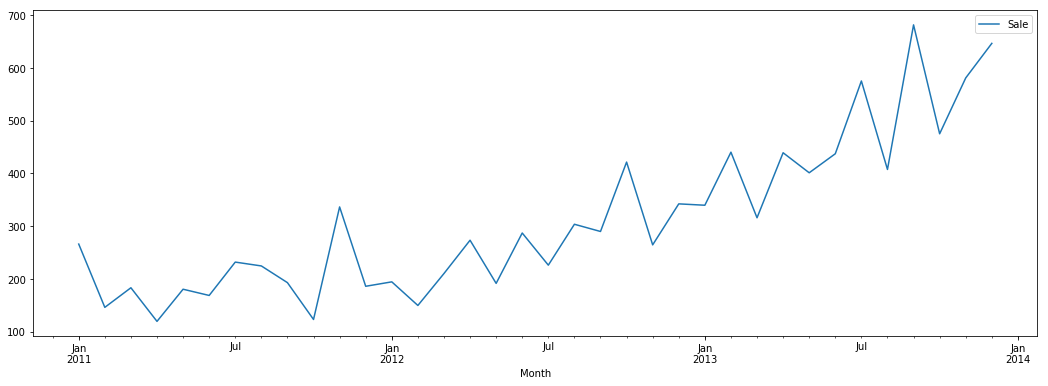

In [73]:
df.plot(figsize=(18,6))

We can see that there is an 'UPWARD' trend in the data.

# Testing Stationarity :

In [74]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()

    #Plot rolling statistics:
    plt.figure(figsize=(18,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

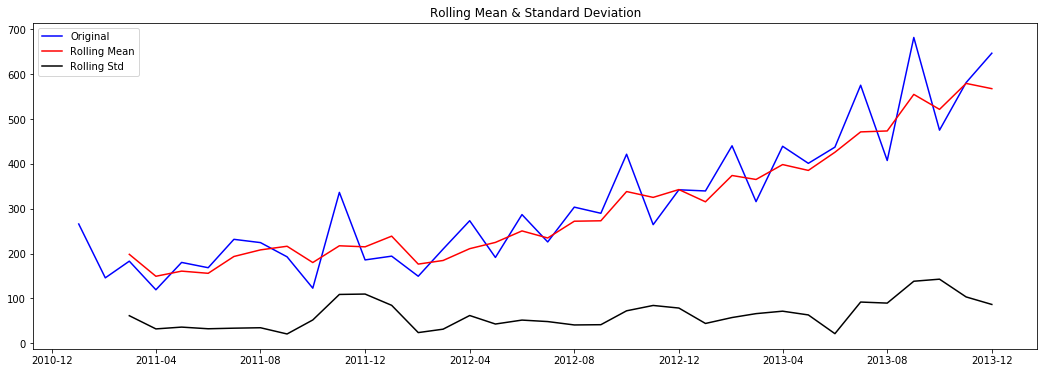

Results of Dickey-Fuller Test:
Test Statistic                  3.060142
p-value                         1.000000
#Lags Used                     10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


In [75]:
test_stationarity(df['Sale'])

From the plot and the results of Advanced Decay-Fuller Test we can conclude that the time is non - stationary right now so we have to make it stationary by differencing.(Test statistics < Critical values and no constant mean.)

# Making Time Series Stationary :

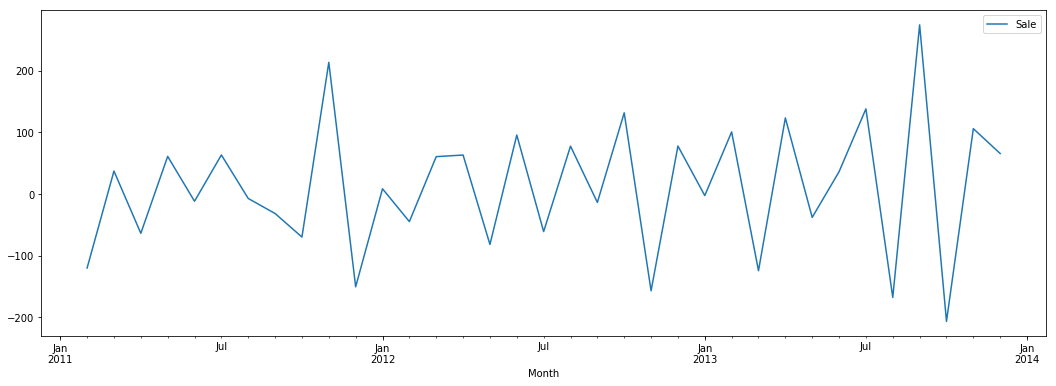

In [76]:
df_new = df
df_new['Sale'] = df['Sale'] - df['Sale'].shift()
df_new.dropna(inplace = True)
df_new.plot(figsize=(18,6))

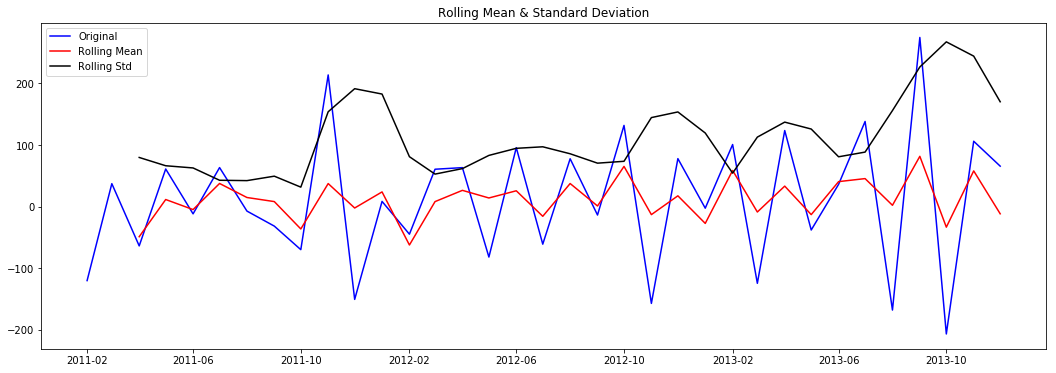

Results of Dickey-Fuller Test:
Test Statistic                -7.249074e+00
p-value                        1.799857e-10
#Lags Used                     1.000000e+00
Number of Observations Used    3.300000e+01
Critical Value (1%)           -3.646135e+00
Critical Value (5%)           -2.954127e+00
Critical Value (10%)          -2.615968e+00
dtype: float64


In [77]:
test_stationarity(df_new['Sale'])

Ok , so now the confidence level is greater than 99% and the p-value is also lesser than 0.5 . so now we can apply ARIMA model since our time-series has become stationary.

# Applying ARIMA Model :

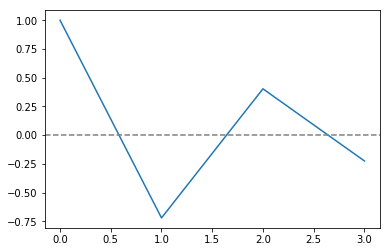

In [78]:
from statsmodels.tsa.stattools import acf,pacf
lag_acf = acf(df_new, nlags=3)
lag_pacf = pacf(df_new, nlags=3, method='ols')
 #Plot ACF: 
plt.plot(lag_acf)


#Plot PACF:


plt.axhline(y=0,linestyle='--',color='gray')


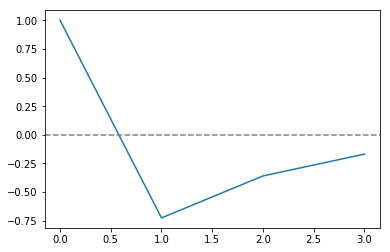

In [79]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')


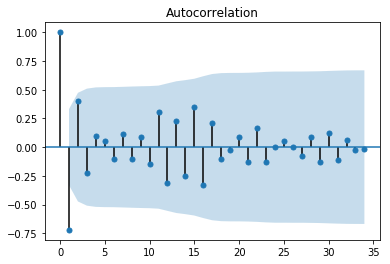

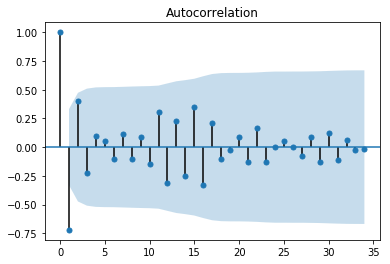

In [80]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(df_new, ax=plt.gca())

In [81]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# evaluate parameters
p_values = range(0,4)
d_values = range(0, 4)
q_values = range(0,4)
warnings.filterwarnings('ignore')
evaluate_models(df_new['Sale'], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=126.629
ARIMA(0, 0, 1) MSE=93.254
ARIMA(0, 1, 0) MSE=240.768
ARIMA(0, 1, 1) MSE=129.450
ARIMA(0, 2, 0) MSE=467.943
ARIMA(0, 2, 1) MSE=247.146
ARIMA(1, 0, 0) MSE=80.044
ARIMA(1, 0, 1) MSE=84.043
ARIMA(1, 1, 0) MSE=125.171
ARIMA(1, 2, 0) MSE=210.863
ARIMA(2, 0, 0) MSE=74.318
ARIMA(2, 1, 0) MSE=97.561
ARIMA(2, 2, 0) MSE=149.542
ARIMA(3, 0, 0) MSE=78.701
ARIMA(3, 0, 1) MSE=86.732
ARIMA(3, 1, 0) MSE=96.426
ARIMA(3, 2, 0) MSE=140.429
Best ARIMA(2, 0, 0) MSE=74.318


Best model is with values p=2,d=0,q=0.

Text(0.5,1,'RSS: 172505.9783')

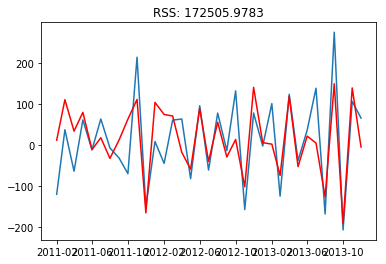

In [82]:
model = ARIMA(df['Sale'],order=(2,0,0))
result = model.fit(disp=0)
plt.plot(df)
plt.plot(result.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((result.fittedvalues-df['Sale'])**2))

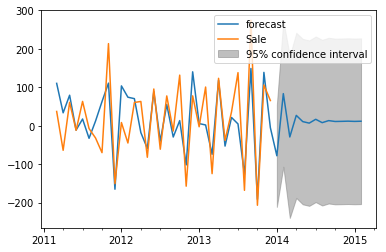

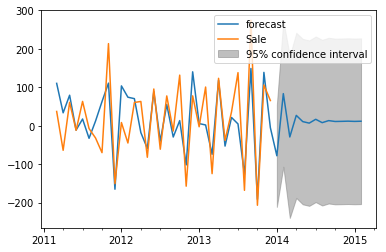

In [83]:
result.plot_predict(1,48)

In [84]:
predictions = pd.Series(result.fittedvalues,copy=True)
print(predictions.head())

Month
2011-02-01     11.650442
2011-03-01    110.286972
2011-04-01     33.690072
2011-05-01     79.446022
2011-06-01    -11.220964
dtype: float64


In [85]:
pred_cumsum = predictions.cumsum()
print(pred_cumsum.head())

Month
2011-02-01     11.650442
2011-03-01    121.937414
2011-04-01    155.627485
2011-05-01    235.073508
2011-06-01    223.852544
dtype: float64


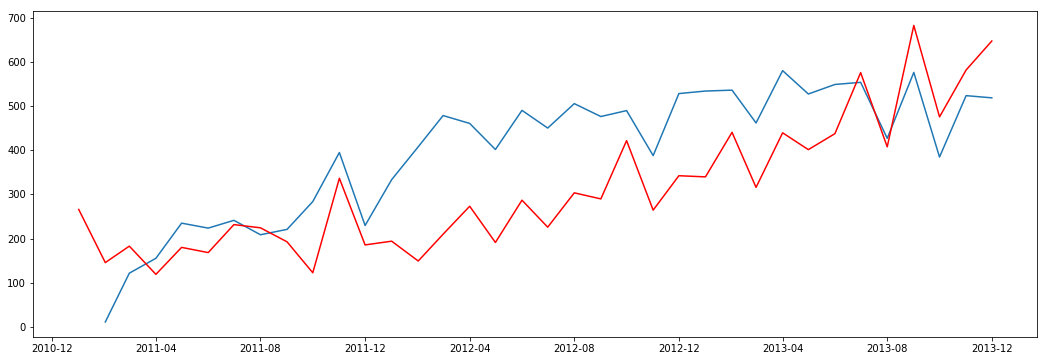

In [90]:
t=pd.read_csv('shampoo.csv')
t.dropna(axis=0,inplace=True)
t['Month'] = '201' + t['Month']
t['Month'] = pd.to_datetime(t['Month'])
t.set_index('Month',inplace=True)
plt.figure(figsize=(18,6))
plt.plot(pred_cumsum)
plt.plot(t,color='red')

In [91]:
result.forecast(steps=12)

(array([-77.99174026,  83.57335961, -29.11067629,  27.03110752,
         10.82607448,   6.87101944,  16.83790069,   8.09422519,
         13.3898455 ,  11.17213205,  11.503614  ,  11.97538671]),
 array([ 67.83250514,  97.00637487, 107.40310605, 109.5892451 ,
        109.72295848, 109.74975927, 109.84030015, 109.90165854,
        109.92218131, 109.92530881, 109.92533195, 109.92557298]),
 array([[-210.94100731,   54.95752679],
        [-106.55564139,  273.70236062],
        [-239.61689598,  181.3955434 ],
        [-187.75986597,  241.82208102],
        [-204.22697242,  225.87912137],
        [-208.23455605,  221.97659493],
        [-198.44513165,  232.12093303],
        [-207.30906739,  223.49751776],
        [-202.05367096,  228.83336196],
        [-204.27751421,  226.62177832],
        [-203.94607761,  226.9533056 ],
        [-203.47477731,  227.42555073]]))